In [31]:
import pandas as pd

In [32]:
%run setup.ipynb

In [148]:
predictions = pd.read_csv(f"../data/predictions/predictions-{11}-{6}.csv")

predictions.drop(predictions.columns[0], axis=1, inplace=True)
predictions.rename(columns={list(predictions)[0]:'date'}, inplace=True)
predictions['date'] = pd.to_datetime(predictions['date'], errors='coerce')

In [149]:
sales = pd.DataFrame(predictions.sales)

errors = predictions.drop(predictions.columns[[0, 1, 2]], axis=1)\
    .sub(sales.sales, axis=0)

In [150]:
def create_features(df):
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    
    return X

In [151]:
create_features(predictions)

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
0,6,3,7,2016,185,3,26
1,0,3,7,2016,186,4,27
2,1,3,7,2016,187,5,27
3,2,3,7,2016,188,6,27
4,3,3,7,2016,189,7,27
...,...,...,...,...,...,...,...
272401,2,4,12,2017,361,27,52
272402,3,4,12,2017,362,28,52
272403,4,4,12,2017,363,29,52
272404,5,4,12,2017,364,30,52


In [56]:
import matplotlib.pyplot as plt


(-50.0, 50.0)

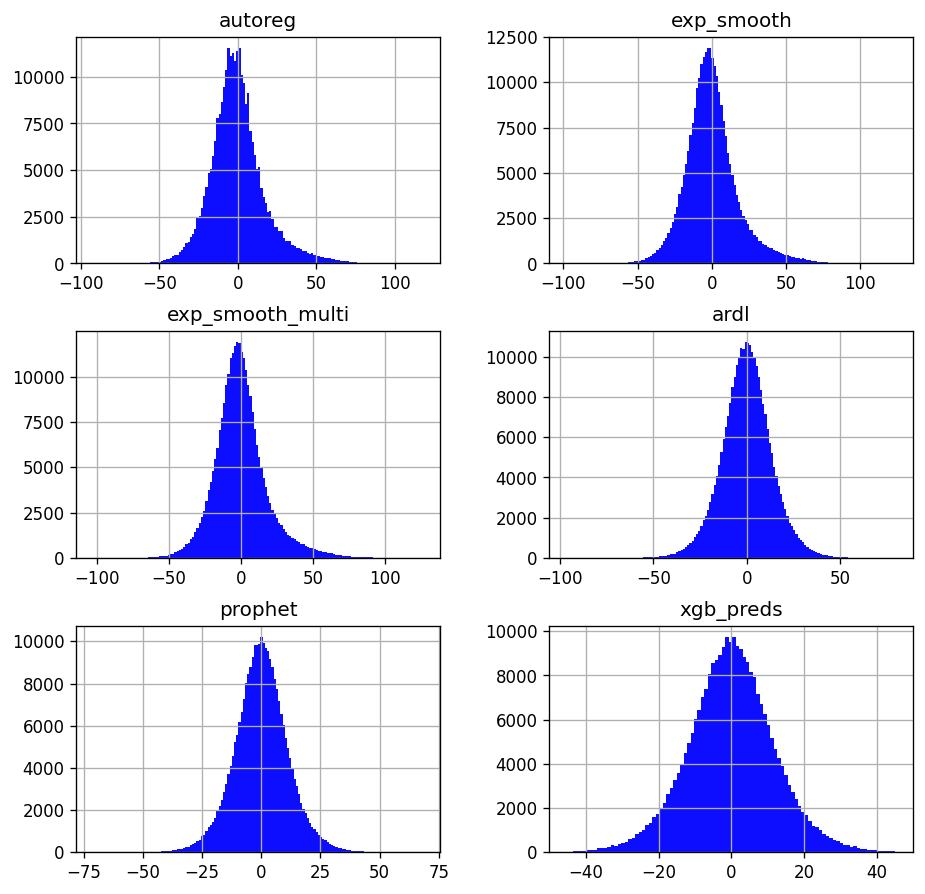

In [102]:
plt.rcParams.update({'figure.figsize':(9,9), 'figure.dpi':120})

errors.diff().hist(bins=150, facecolor='blue', alpha=0.95, )

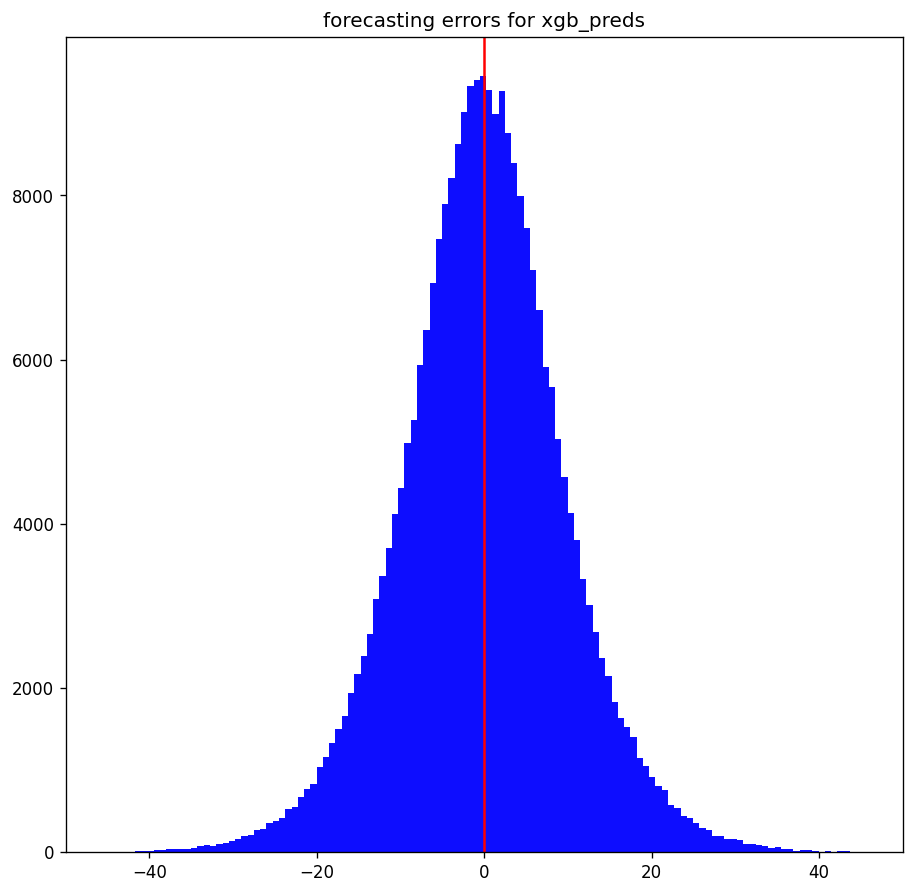

In [114]:
def fcast_errors(col="prophet"):
    plt.hist(errors[col], 150, facecolor='blue', alpha=0.95)
    plt.axvline(x=0, c="red")
    plt.title(f"forecasting errors for {col}")
    plt.xlim((-50, 50))
    plt.show()
fcast_errors("xgb_preds")

In [90]:
errors.std()\
    .sort_values()

prophet              8.671700
xgb_preds            9.815760
ardl                10.518724
exp_smooth          14.120232
autoreg             14.125726
exp_smooth_multi    14.486537
dtype: float64

In [115]:
predictions.drop(predictions.)

,Unnamed: 0,Unnamed: 0.1,store_item,sales,autoreg,exp_smooth,exp_smooth_multi,ardl,prophet,xgb_preds
0,0,2016-07-03,1-1,35,33.564926,34.968360,37.358205,28.270421,31.430007,42.183426
1,1,2016-07-04,1-1,18,25.371284,27.868874,29.091349,21.079731,23.552477,20.786821
2,2,2016-07-05,1-1,31,27.200800,26.861003,27.695462,21.245674,26.190409,23.284859
3,3,2016-07-06,1-1,22,28.000816,28.344893,29.004482,27.543148,26.846605,26.260480
4,4,2016-07-07,1-1,33,26.200584,25.971329,26.564866,29.099083,27.095248,26.110456
...,...,...,...,...,...,...,...,...,...,...
272401,272401,2017-12-27,10-50,63,54.036777,70.629780,65.336560,52.203080,60.990158,59.709023
272402,272402,2017-12-28,10-50,59,48.369474,64.050097,56.627964,60.144470,64.923885,66.095240
272403,272403,2017-12-29,10-50,74,41.368979,56.527002,50.323118,60.437527,69.576875,70.068820
272404,272404,2017-12-30,10-50,62,43.701682,59.522268,52.400913,69.928363,74.064814,69.177450


In [ ]:
a

In [15]:
store_sales = pd.concat([train, predictions])

In [25]:
for column in predictions.columns[4:]:
    col = (predictions[column] - predictions.sales)
    col_mean = np.mean(col)
    print(column, col_mean)
    

autoreg 265.51425363913745
exp_smooth 201.47745513910357
exp_smooth_multi 210.55209317543023
ardl 123.13930015554452
prophet 75.47416465386237
xgb_preds 96.35763653069395
